In [1]:
import os
import sys
import csv
import math
import h5py
import argparse
import numpy as np
import xml.etree.ElementTree as et 
from collections import Counter, defaultdict

# Keras imports
from keras.models import Model
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from keras.layers import Input, Dense, Dropout, AlphaDropout, BatchNormalization, Activation

# ML4CVD Imports
from ml4cvd.plots import plot_ecg
from ml4cvd.arguments import parse_args
from ml4cvd.recipes import train_multimodal_multitask

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '


In [5]:
stats = Counter()
DATA_DIRECTORY = '/mnt/disks/sax-lax-40k/2019-11-08/'
with open('/home/sam/lvh_hold_out.txt', 'r') as volumes:
    lol = list(csv.reader(volumes, delimiter=','))
    with open('/home/sam/lvh_hold_out_no_poor_new.txt', 'w') as lvh:
        for row in lol[0:]:
            if not os.path.exists(os.path.join(DATA_DIRECTORY, row[0] + '.hd5')):
                stats['missing'] += 1
                continue
            with h5py.File(os.path.join(DATA_DIRECTORY, row[0] + '.hd5')) as hd5:
                skip = False
                if 'Poor data quality' in str(hd5['ecg_rest_text'][0]):
                    stats['poor quality'] += 1
                    skip = True
                if 'ecg_rest_text' not in hd5:
                    stats['missing ecg'] += 1
                    skip = True
                if 'systole_frame_b2' not in hd5:
                    stats['missing MRI'] += 1
                    skip = True 

                if not skip:
                    stats['written'] += 1
                    lvh.write(row[0] + '\n')

print(stats)

Counter({'written': 5062, 'poor quality': 224, 'missing': 113, 'missing MRI': 107})


In [ ]:
stats = Counter()
DATA_DIRECTORY = '/mnt/disks/sax-lax-40k/2019-11-08/'
with open('/home/sam/lvh_hold_out.txt', 'r') as volumes:
    lol = list(csv.reader(volumes, delimiter=','))
    holdout = [row[0] + '.hd5' for row in lol]
    with open('/home/sam/lvh_hold_out_no_poor_new.txt', 'w') as lvh:
        for file in sorted(os.listdir(DATA_DIRECTORY)):
            if file[-4:] != '.hd5':
                continue
            try:
                with h5py.File(os.path.join(DATA_DIRECTORY, file)) as hd5:
                    skip = False
                    if 'ecg_rest_text' in hd5 and 'Poor data quality' in str(hd5['ecg_rest_text'][0]):
                        stats['poor quality'] += 1
                        skip = True
                    if 'ecg_rest_text' not in hd5:
                        stats['missing ecg'] += 1
                        skip = True
                    if 'systole_frame_b2' not in hd5:
                        stats['missing MRI'] += 1
                        skip = True 
                        
                    if file in holdout:
                        stats['in holdout'] += 1
                        if not skip:
                            lvh.write(file.replace('.hd5', '') + '\n')
                        #skip = True

                    if not skip:
                        stats['got it all'] += 1
                        #lvh.write(file.replace('.hd5', '') + '\n')
            except:
                stats[f'failed to open {file}'] += 1
print(stats)

In [5]:
print(stats)

Counter({'got it all': 7653, 'in holdout': 1635, 'missing ecg': 1549, 'missing MRI': 793, 'poor quality': 322})


In [9]:
DATA_DIRECTORY = '/mnt/disks/lax-and-sax-tensors/2017-07-30/'
summary_dict = defaultdict(Counter)
def return_rhythm_class(hd5):
    if 'poor_data_quality' in hd5['categorical']:
        return 'poor_data_quality'
    for rhythm in ('Normal_sinus_rhythm', 'Sinus_bradycardia', 'Marked_sinus_bradycardia'):
        if rhythm in hd5['categorical']:
            return 'Sinus_rhythm'
    if 'Atrial_fibrillation' in hd5['categorical']:
        return 'Atrial_fibirillation'    
    return 'Other_rhythm'

def new_rhythm(hd5):
    if 'poor_data_quality' in hd5['categorical']:
        return 'poor_data_quality'
    ecg_interpretation = str(hd5['ecg_rest_text'][0])
    for afib in ['Atrial fibrillation']:
        if afib in ecg_interpretation:
            return 'Atrial_fibrillation'
    for rhythm in ['sinus', 'Sinus']:
        if rhythm in ecg_interpretation:
            return 'Sinus_rhythm'
    return 'Other_rhythm'

channel_map={'Normal_sinus_rhythm': 0, 'Sinus_bradycardia': 1, 'Marked_sinus_bradycardia': 2, 'Other_sinus_rhythm': 3, 'Atrial_fibrillation': 4, 'Other_rhythm': 5}
def semi_coarse_rhythm(hd5):
#     if 'poor_data_quality' in hd5['categorical']:
#         return 'poor_data_quality'
    ecg_interpretation = str(hd5['ecg_rest_text'][0])
    for channel in channel_map:
        if channel in hd5['categorical']:
            return channel
    for afib in ['Atrial fibrillation']:
        if afib in ecg_interpretation:
            return 'Atrial_fibrillation'
    for rhythm in ['sinus', 'Sinus']:
        if rhythm in ecg_interpretation:
            return 'Other_sinus_rhythm'
    return 'Other_rhythm'

num_files = 0
a_fib_tab = np.zeros((6, 2))
brady_tab = np.zeros((6, 2))
for file in os.listdir(DATA_DIRECTORY):
    if file[-4:] != '.hd5':
        continue
    num_files += 1
    if num_files % 1000 == 0:
        print('.')
    with h5py.File(os.path.join(DATA_DIRECTORY, file)) as hd5:
        summary_dict[semi_coarse_rhythm(hd5)].update(hd5['ecg_rest_text'][:])
        a_fib = 1 if 'atrial_fibrillation_or_flutter' in hd5 and int(hd5['atrial_fibrillation_or_flutter'][0]) != 0 else 0
        brady = 1 if 'bradyarrhythmia_general_inclusive_definition' in hd5 and int(hd5['bradyarrhythmia_general_inclusive_definition'][0]) != 0 else 0
        a_fib_tab[channel_map[semi_coarse_rhythm(hd5)], a_fib] += 1
        brady_tab[channel_map[semi_coarse_rhythm(hd5)], brady] += 1
# with open('semi_coarse_rhythm_summary2.csv', mode='w') as file_:
#     file_writer = csv.writer(file_, delimiter=',', quotechar='\'', quoting=csv.QUOTE_MINIMAL)
#     for key, counter in summary_dict.items():
#         for text, count in counter.most_common():
#             file_writer.writerow([key, text, count])
print(a_fib_tab)

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
[[1.4142e+04 1.4000e+02]
 [1.0404e+04 1.8300e+02]
 [2.7940e+03 7.0000e+01]
 [2.0320e+03 3.8000e+01]
 [2.0600e+02 1.7000e+02]
 [3.1300e+02 1.4000e+01]]


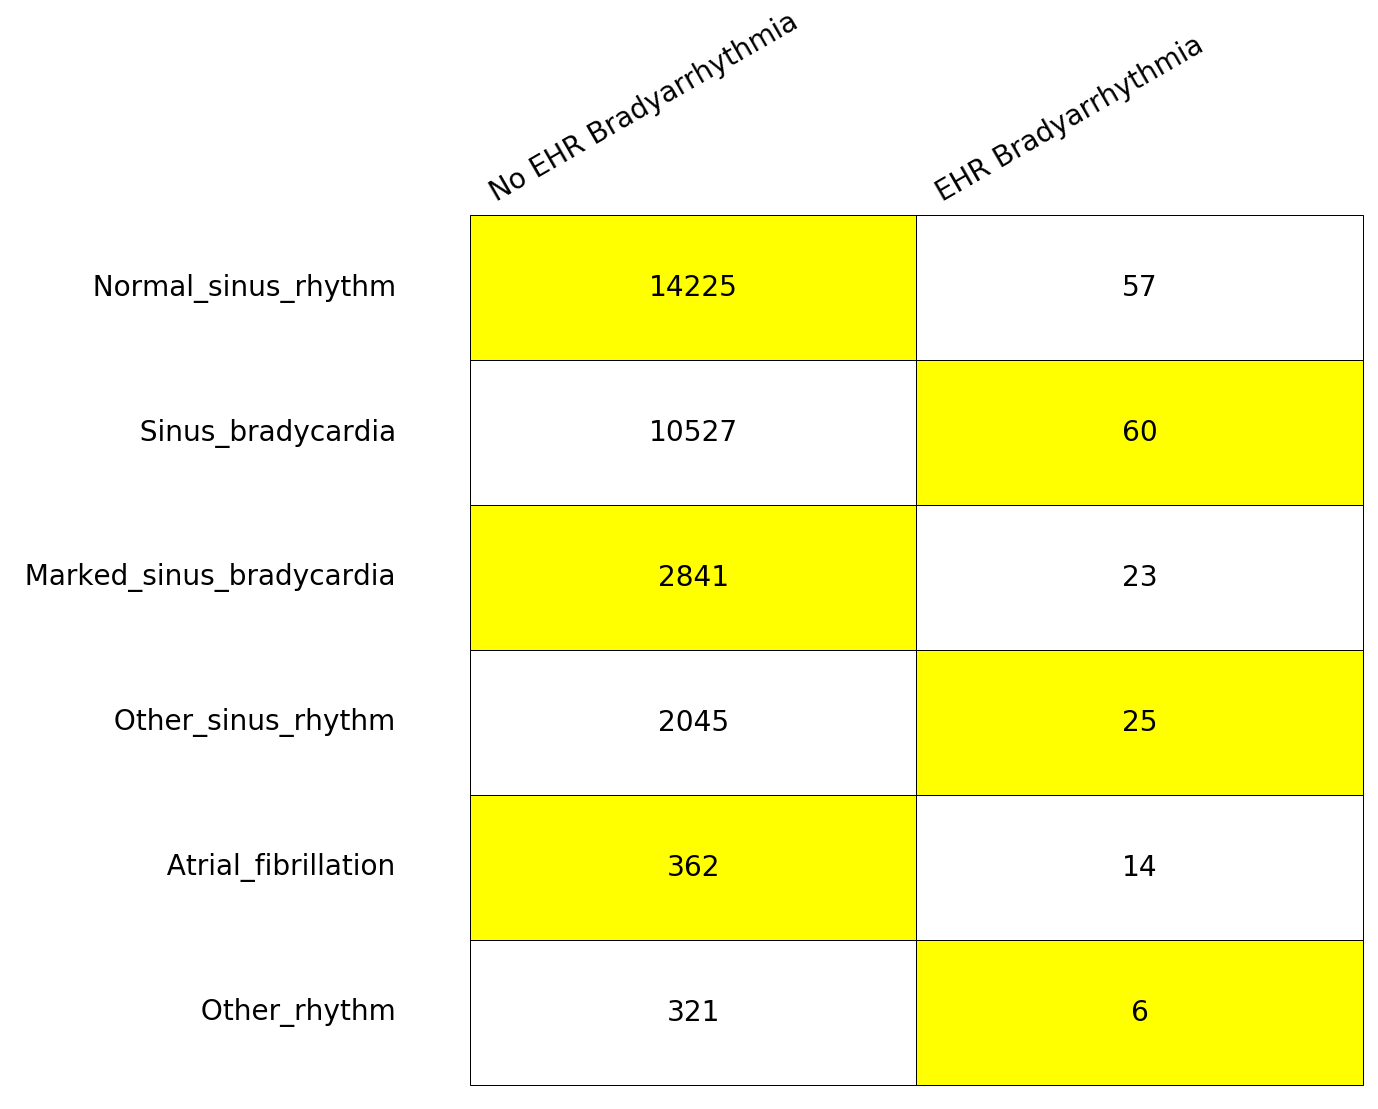

In [11]:
from matplotlib.table import Table
afibs = ['No EHR Bradyarrhythmia', 'EHR Bradyarrhythmia']  # ['No EHR aFib', 'EHR aFib']
nrows = len(channel_map)
ncols = len(afibs)
def checkerboard_table(data, fmt='{:1.0f}', bkg_colors=['yellow', 'white']):
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_axis_off()
    tb = Table(ax, bbox=[0,0,1,1])

    width, height = 1.0 / ncols, 1.0 / nrows
    
    # Add cells
    for (i,j), val in np.ndenumerate(data):
        # Index either the first or second item of bkg_colors based on a checker board pattern
        idx = [j % 2, (j + 1) % 2][i % 2]
        color = bkg_colors[idx]
        tb.add_cell(i, j, width, height, text=fmt.format(val), loc='center', facecolor=color)

    # Labels...
    col_offset = height/2
    row_offset = -width/6
    font_size = 28
    for count, string in enumerate(afibs):
        ax.annotate('  '+string, xy=(count*width, 1), xycoords='axes fraction', ha='left', va='bottom', 
                    rotation=30, size=font_size)    
    for count, string in enumerate(reversed(list(channel_map.keys()))):
        ax.annotate('  '+string, xy=(row_offset, col_offset +count*height), xycoords='axes fraction', ha='right', 
                    va='center', size=font_size)      
    
    tb.auto_set_font_size(False)
    tb.set_fontsize(font_size)
    ax.add_table(tb)
    return fig

checkerboard_table(brady_tab)
plt.show()